# 🌍 Présentation du projet : Prédiction de la pollution de l'air (PM10) à Casablanca

Ce notebook détaille un projet axé sur la prédiction des concentrations quotidiennes de pollution de l'air (PM10) à Casablanca, Maroc.

Il utilise des données provenant de deux sources principales :
*   **OpenAQ :** Fournit des données historiques sur la qualité de l'air, spécifiquement les mesures de PM10.
*   **Meteostat :** Offre des données météorologiques historiques (température, précipitations, vitesse du vent, pression atmosphérique).

Le projet suit un processus standard d'exploration de données / KDD (Knowledge Discovery in Databases) :

1.  **Collecte de données :** Rassemblement des données brutes provenant des sources.
2.  **Nettoyage des données :** Gestion des valeurs manquantes, des valeurs aberrantes et des incohérences.
3.  **Transformation des données :** Ingénierie des caractéristiques (feature engineering) et préparation des données pour la modélisation.
4.  **Modélisation :** Sélection, entraînement et ajustement des modèles prédictifs.
5.  **Évaluation :** Évaluation des performances du modèle.

**Objectif :** Le but ultime est de préparer un jeu de données robuste et riche en caractéristiques, et de développer des modèles d'apprentissage automatique précis capables de prévoir les niveaux de PM10 24 heures à l'avance.

### Configuration de l'environnement et import des bibliothèques

Dans ce premier bloc de code, les bibliothèques Python essentielles au projet (comme `pandas` pour la manipulation de données, `numpy` pour les opérations numériques, `matplotlib` et `seaborn` pour la visualisation) sont importées.

Des configurations d'affichage pour les DataFrames pandas sont également appliquées afin d'améliorer la lisibilité des tableaux de données.

In [56]:
# =========================================================
# A.0 - Configuration de l'environnement et import des libs
# =========================================================

import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
import joblib

# Affichage plus lisible
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

### Chargement des données brutes (Air & Météo)

Les fichiers CSV contenant les données OpenAQ (qualité de l'air) et Meteostat (météo) sont lus. Le notebook vérifie si Google Drive est monté (utile si vous exécutez dans Colab) et monte Drive si nécessaire pour accéder aux fichiers.

Deux DataFrames sont créés : `df_air` pour les données de qualité de l'air et `df_weather` pour les données météorologiques. Un aperçu des premières lignes est affiché pour vérifier le chargement.

In [57]:
# =========================================================
# A.1 - Chargement des données brutes (Air & Météo)
# =========================================================

# Si vous avez monté Google Drive :
drive.mount('/content/drive')

# --- Chemins vers vos fichiers (à adapter selon votre Drive) ---
air_path = "/content/drive/MyDrive/Project-Controle-ML/casablanca_pm10_full.csv"
weather_path = "/content/drive/MyDrive/Project-Controle-ML/meteo.csv"


# --- Lecture des fichiers CSV ---
df_air = pd.read_csv(air_path)
df_weather = pd.read_csv(weather_path)

# --- Vérification du chargement ---
print("✅ Données chargées avec succès !")
print(f"Air quality: {df_air.shape[0]} lignes × {df_air.shape[1]} colonnes")
print(f"Weather: {df_weather.shape[0]} lignes × {df_weather.shape[1]} colonnes")

# --- Aperçu rapide ---
print("\nAperçu des données Air Quality:")
display(df_air.head(3))

print("\nAperçu des données Météo:")
display(df_weather.head(3))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Données chargées avec succès !
Air quality: 49954 lignes × 24 colonnes
Weather: 3528 lignes × 11 colonnes

Aperçu des données Air Quality:


,value,coordinates,summary,flagInfo.hasFlags,parameter.id,parameter.name,parameter.units,parameter.displayName,period.label,period.interval,period.datetimeFrom.utc,period.datetimeFrom.local,period.datetimeTo.utc,period.datetimeTo.local,coverage.expectedCount,coverage.expectedInterval,coverage.observedCount,coverage.observedInterval,coverage.percentComplete,coverage.percentCoverage,coverage.datetimeFrom.utc,coverage.datetimeFrom.local,coverage.datetimeTo.utc,coverage.datetimeTo.local
0,44.0,NaN,NaN,False,1,pm10,µg/m³,NaN,raw,01:00:00,2025-10-05T16:00:00Z,2025-10-05T09:00:00-07:00,2025-10-05T17:00:00Z,2025-10-05T10:00:00-07:00,1,01:00:00,1,01:00:00,100.0,100.0,2025-10-05T16:00:00Z,2025-10-05T09:00:00-07:00,2025-10-05T17:00:00Z,2025-10-05T10:00:00-07:00
1,36.0,NaN,NaN,False,1,pm10,µg/m³,NaN,raw,01:00:00,2025-10-05T17:00:00Z,2025-10-05T10:00:00-07:00,2025-10-05T18:00:00Z,2025-10-05T11:00:00-07:00,1,01:00:00,1,01:00:00,100.0,100.0,2025-10-05T17:00:00Z,2025-10-05T10:00:00-07:00,2025-10-05T18:00:00Z,2025-10-05T11:00:00-07:00
2,34.0,NaN,NaN,False,1,pm10,µg/m³,NaN,raw,01:00:00,2025-10-05T18:00:00Z,2025-10-05T11:00:00-07:00,2025-10-05T19:00:00Z,2025-10-05T12:00:00-07:00,1,01:00:00,1,01:00:00,100.0,100.0,2025-10-05T18:00:00Z,2025-10-05T11:00:00-07:00,2025-10-05T19:00:00Z,2025-10-05T12:00:00-07:00



Aperçu des données Météo:


,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2016-03-09 00:00:00,14.8,9.0,17.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-03-10 00:00:00,14.4,NaN,16.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-03-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Inspection & typage des colonnes

Les premières lignes de chaque jeu de données sont affichées.
Les colonnes de date sont converties au format datetime.
Seules les colonnes pertinentes sont sélectionnées (par exemple, datetime, valeur, polluant, température, etc.).

In [58]:
# =========================================================
# A.2 - Inspection & typage des colonnes
# =========================================================

# --- Conversion des dates ---
# Le dataset Air Quality contient les dates dans la colonne "period.datetimeFrom.utc"
# Le dataset Météo contient les dates dans la colonne "date"
df_air['datetimeUtc'] = pd.to_datetime(df_air['period.datetimeFrom.utc'], utc=True, errors='coerce')
df_weather['date'] = pd.to_datetime(df_weather['date'], utc=True, errors='coerce')

# --- Sélection des colonnes utiles ---
# On conserve uniquement les champs pertinents pour nos analyses
air_cols = [
    'datetimeUtc', 'value', 'parameter.name', 'parameter.units',
    'coverage.percentComplete', 'coverage.percentCoverage'
]
df_air = df_air[air_cols]

weather_cols = [
    'date', 'tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres'
]
df_weather = df_weather[weather_cols]

print("\n✅ Colonnes sélectionnées et typées avec succès !")
print(f"Air: {df_air.shape[1]} colonnes | Weather: {df_weather.shape[1]} colonnes")



✅ Colonnes sélectionnées et typées avec succès !
Air: 6 colonnes | Weather: 7 colonnes


### Normalisation du fuseau horaire (UTC)

Les horodatages sont normalisés en UTC (Coordinated Universal Time).
Les dates météorologiques sont décalées à 23:59 UTC pour correspondre à la fréquence quotidienne.
Cela garantit la cohérence des fuseaux horaires avant la fusion des données.

In [59]:
# =========================================================
# A.3 - Normalisation du fuseau horaire (UTC)
# =========================================================

# Air Quality : les dates sont déjà en UTC, mais on force la cohérence
df_air['datetime_utc'] = df_air['datetimeUtc'].dt.tz_convert('UTC')

# Weather : données journalières → on associe la fin de journée (23h59 UTC)
# Cela permet de les aligner temporellement avec les mesures horaires de la qualité de l'air.
df_weather['datetime_utc'] = df_weather['date'] + pd.Timedelta(hours=23, minutes=59)
df_weather = df_weather.drop(columns='date')

print("✅ Fuseau horaire normalisé pour Air et Météo")
display(df_air[['datetime_utc', 'value']].head(3))
display(df_weather[['datetime_utc', 'tavg']].head(3))


✅ Fuseau horaire normalisé pour Air et Météo


,datetime_utc,value
0,2025-10-05 16:00:00+00:00,44.0
1,2025-10-05 17:00:00+00:00,36.0
2,2025-10-05 18:00:00+00:00,34.0


,datetime_utc,tavg
0,2016-03-09 23:59:00+00:00,14.8
1,2016-03-10 23:59:00+00:00,14.4
2,2016-03-11 23:59:00+00:00,NaN


### Fusion et agrégation quotidienne (alignement Air + Météo)

Les données Air sont transformées du format long au format large en utilisant un tableau croisé dynamique. Chaque ligne représente un horodatage unique, et chaque polluant (PM1, PM2.5, PM10) devient une colonne distincte. Les noms de colonnes sont renommés pour être plus explicites (PM10_ug_m3, etc.).

Ensuite, les données de qualité de l'air sont agrégées à une fréquence quotidienne (moyenne journalière de PM10) pour correspondre aux données météorologiques.

Enfin, les jeux de données Air Quality agrégé et Météo sont fusionnés sur la base de la date. Cela crée un jeu de données unifié prêt pour l'analyse et la modélisation.

In [60]:
# =========================================================
# A.4 - Fusion et agrégation quotidienne (alignement Air + Météo)
# =========================================================

# --- 1️⃣ Agrégation des mesures horaires Air -> moyennes journalières ---
# On crée une nouvelle colonne "date" pour regrouper par jour
df_air['date'] = df_air['datetime_utc'].dt.floor('D')

# Calcul de la moyenne quotidienne de PM10
daily_air = (
    df_air.groupby('date')['value']
    .mean()
    .reset_index()
    .rename(columns={'value': 'pm10_mean'})
)

print(f"✅ Agrégation Air Quality terminée : {daily_air.shape[0]} jours uniques")

# --- 2️⃣ Préparation du dataset météo ---
# On arrondit aussi la datetime météo à la journée (au cas où)
df_weather['date'] = df_weather['datetime_utc'].dt.floor('D')

# --- 3️⃣ Fusion Air + Météo sur la date ---
df_merged = pd.merge(daily_air, df_weather, on='date', how='inner')

print(f"✅ Fusion Air + Météo réussie : {df_merged.shape[0]} lignes finales")

# --- 4️⃣ Aperçu final ---
print("\n=== Aperçu du jeu de données fusionné ===")
display(df_merged.head(5))


✅ Agrégation Air Quality terminée : 2533 jours uniques
✅ Fusion Air + Météo réussie : 2533 lignes finales

=== Aperçu du jeu de données fusionné ===


,date,pm10_mean,tavg,tmin,tmax,prcp,wspd,pres,datetime_utc
0,2016-03-10 00:00:00+00:00,44.000000,14.4,NaN,16.6,NaN,NaN,NaN,2016-03-10 23:59:00+00:00
1,2016-03-11 00:00:00+00:00,72.571429,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-11 23:59:00+00:00
2,2016-03-12 00:00:00+00:00,56.650000,14.4,7.8,17.7,NaN,NaN,NaN,2016-03-12 23:59:00+00:00
3,2016-03-13 00:00:00+00:00,44.727273,15.1,9.0,18.0,NaN,NaN,NaN,2016-03-13 23:59:00+00:00
4,2016-03-14 00:00:00+00:00,45.894737,15.0,NaN,18.0,NaN,NaN,NaN,2016-03-14 23:59:00+00:00


### Nettoyage final et sauvegarde du dataset fusionné

Les valeurs manquantes sont vérifiées.
Les lignes où la valeur PM10 est manquante sont supprimées (car PM10 est la cible de la prédiction).
Les autres valeurs manquantes sont imputées en utilisant des stratégies appropriées (interpolation pour les données continues comme la température et la pression, et remplissage par zéro pour les précipitations).
Une détection des outliers potentiels dans les données PM10 est effectuée.
La cohérence temporelle du dataset final est vérifiée.
Le dataset nettoyé et fusionné est ensuite sauvegardé dans un fichier CSV.

In [61]:
# =========================================================
# A.5 - Nettoyage final et sauvegarde du dataset fusionné
# =========================================================

# --- 1️⃣ Vérification des valeurs manquantes ---
missing_summary = df_merged.isnull().sum()
print("=== Valeurs manquantes par colonne ===")
print(missing_summary)

# --- 2️⃣ Suppression ou imputation simple ---
# On supprime les jours où la valeur PM10 est manquante (cible principale)
df_clean = df_merged.dropna(subset=['pm10_mean']).copy()

# --- 3️⃣ Traitement différencié selon le % de manquants ---
# Variables avec peu de manquants (< 20%) : interpolation
cols_interpolate = ['tavg', 'tmin', 'tmax', 'wspd', 'pres']
df_clean[cols_interpolate] = df_clean[cols_interpolate].interpolate(
    method='linear',
    limit_direction='both'
)

# Précipitations : remplir NaN par 0 (absence de pluie probable)
df_clean['prcp'] = df_clean['prcp'].fillna(0)

print(f"\n✅ Nettoyage terminé : {df_clean.shape[0]} jours restants après suppression des NaN PM10")
print(f"\n✅ Nettoyage terminé : {df_clean.shape[0]} lignes × {df_clean.shape[1]} colonnes")
print(f"Valeurs manquantes restantes : {df_clean.isnull().sum().sum()}")

# --- 4️⃣Détection d'outliers potentiels sur PM10 ---
Q1 = df_clean['pm10_mean'].quantile(0.25)
Q3 = df_clean['pm10_mean'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_clean[(df_clean['pm10_mean'] < Q1 - 1.5*IQR) |
                     (df_clean['pm10_mean'] > Q3 + 1.5*IQR)]
print(f"\n📈 Outliers PM10 détectés : {len(outliers)} jours ({len(outliers)/len(df_clean)*100:.1f}%)")
print(f"   Plage normale : [{Q1 - 1.5*IQR:.1f}, {Q3 + 1.5*IQR:.1f}]")


# --- 5️⃣ Vérification de la cohérence temporelle ---
print("\nPériode couverte :", df_clean['date'].min(), "→", df_clean['date'].max())

# ---  Sauvegarde du dataset propre ---
output_path = "data_fusionnee_casablanca.csv"
df_clean.to_csv(output_path, index=False)

print(f"\n💾 Fichier nettoyé et fusionné enregistré sous : {output_path}")

# --- Aperçu final ---
display(df_clean.head(5))

missing_summary = df_clean.isnull().sum()
print("=== Valeurs manquantes par colonne ===")
print(missing_summary)


=== Valeurs manquantes par colonne ===
date              0
pm10_mean         0
tavg            116
tmin            215
tmax            116
prcp            793
wspd            464
pres            464
datetime_utc      0
dtype: int64

✅ Nettoyage terminé : 2533 jours restants après suppression des NaN PM10

✅ Nettoyage terminé : 2533 lignes × 9 colonnes
Valeurs manquantes restantes : 0

📈 Outliers PM10 détectés : 54 jours (2.1%)
   Plage normale : [-13.6, 93.7]

Période couverte : 2016-03-10 00:00:00+00:00 → 2025-11-04 00:00:00+00:00

💾 Fichier nettoyé et fusionné enregistré sous : data_fusionnee_casablanca.csv


,date,pm10_mean,tavg,tmin,tmax,prcp,wspd,pres,datetime_utc
0,2016-03-10 00:00:00+00:00,44.000000,14.4,7.800000,16.60,0.0,15.7,1015.6,2016-03-10 23:59:00+00:00
1,2016-03-11 00:00:00+00:00,72.571429,14.4,7.800000,17.15,0.0,15.7,1015.6,2016-03-11 23:59:00+00:00
2,2016-03-12 00:00:00+00:00,56.650000,14.4,7.800000,17.70,0.0,15.7,1015.6,2016-03-12 23:59:00+00:00
3,2016-03-13 00:00:00+00:00,44.727273,15.1,9.000000,18.00,0.0,15.7,1015.6,2016-03-13 23:59:00+00:00
4,2016-03-14 00:00:00+00:00,45.894737,15.0,9.166667,18.00,0.0,15.7,1015.6,2016-03-14 23:59:00+00:00


=== Valeurs manquantes par colonne ===
date            0
pm10_mean       0
tavg            0
tmin            0
tmax            0
prcp            0
wspd            0
pres            0
datetime_utc    0
dtype: int64


### Statistiques descriptives & aperçu global

Les dimensions du jeu de données final sont affichées.
Des statistiques descriptives globales (moyenne, médiane, écart-type, min, max, quartiles) sont calculées pour les variables numériques.
La période temporelle couverte par les données est vérifiée.
La distribution des concentrations de PM10 est visualisée à l'aide d'un histogramme et d'une courbe de densité.
L'évolution quotidienne des niveaux de PM10 est affichée sous forme de série temporelle pour observer les tendances générales.

Dataset final : 2533 jours × 9 variables

=== Statistiques descriptives ===


,pm10_mean,tavg,tmin,tmax,prcp,wspd,pres
count,2533.00,2533.00,2533.00,2533.00,2533.00,2533.00,2533.00
mean,42.25,19.59,15.43,22.73,0.80,12.11,1017.18
std,25.41,3.93,4.63,3.85,3.88,3.87,4.19
min,2.67,9.40,3.30,11.20,0.00,3.50,1001.70
25%,26.65,16.30,11.80,19.60,0.00,8.90,1015.20
50%,40.50,19.80,15.70,22.80,0.00,11.90,1015.90
75%,53.46,22.80,19.50,25.50,0.00,15.70,1019.20
max,448.00,36.00,26.40,40.50,79.00,24.80,1031.30



Période des mesures :
De 2016-03-10 à 2025-11-04


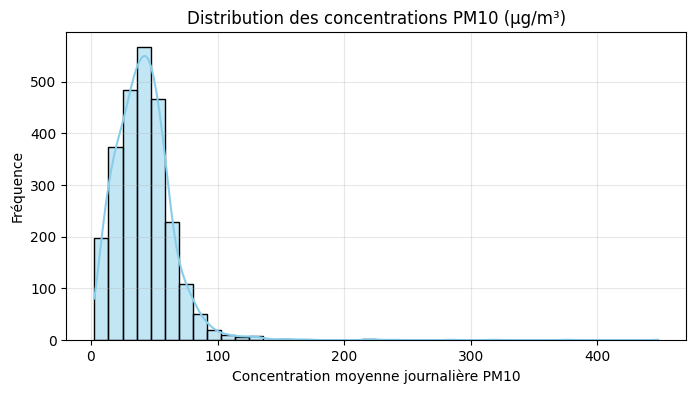

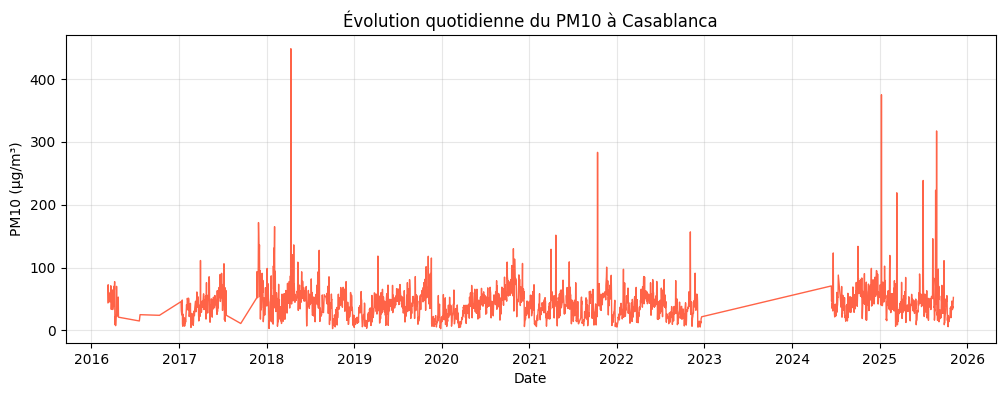

In [62]:
# =========================================================
# B.1 - Statistiques descriptives & aperçu global
# =========================================================

# --- 1️⃣ Dimensions du dataset ---
print(f"Dataset final : {df_clean.shape[0]} jours × {df_clean.shape[1]} variables")

# --- 2️⃣ Statistiques globales ---
print("\n=== Statistiques descriptives ===")
display(df_clean.describe().round(2))

# --- 3️⃣ Période temporelle couverte ---
print("\nPériode des mesures :")
print(f"De {df_clean['date'].min().strftime('%Y-%m-%d')} à {df_clean['date'].max().strftime('%Y-%m-%d')}")

# --- 4️⃣ Vérification de la distribution du PM10 ---
plt.figure(figsize=(8,4))
sns.histplot(df_clean['pm10_mean'], bins=40, color='skyblue', kde=True)
plt.title("Distribution des concentrations PM10 (µg/m³)")
plt.xlabel("Concentration moyenne journalière PM10")
plt.ylabel("Fréquence")
plt.grid(alpha=0.3)
plt.show()

# --- 5️⃣ Aperçu de la série temporelle ---
plt.figure(figsize=(12,4))
plt.plot(df_clean['date'], df_clean['pm10_mean'], color='tomato', linewidth=1)
plt.title("Évolution quotidienne du PM10 à Casablanca")
plt.xlabel("Date")
plt.ylabel("PM10 (µg/m³)")
plt.grid(alpha=0.3)
plt.show()


### Corrélations entre météo et pollution (PM10)

Les corrélations entre les variables météorologiques et les concentrations de PM10 sont analysées.
Seules les variables numériques sont sélectionnées pour le calcul de la matrice de corrélation de Pearson.
La matrice de corrélation est affichée numériquement.
Une heatmap est générée pour visualiser les forces et directions des corrélations.
Des scatter plots avec régression linéaire sont tracés pour mieux comprendre les relations entre PM10 et certaines variables clés (température, précipitations, vent, pression).

=== Matrice des corrélations (Pearson) ===


,pm10_mean,tavg,tmin,tmax,prcp,wspd,pres
pm10_mean,1.00,0.08,0.08,0.08,-0.00,0.04,-0.07
tavg,0.08,1.00,0.92,0.95,-0.21,0.01,-0.38
tmin,0.08,0.92,1.00,0.81,-0.13,0.07,-0.41
tmax,0.08,0.95,0.81,1.00,-0.23,-0.10,-0.29
prcp,-0.00,-0.21,-0.13,-0.23,1.00,0.09,-0.18
wspd,0.04,0.01,0.07,-0.10,0.09,1.00,-0.30
pres,-0.07,-0.38,-0.41,-0.29,-0.18,-0.30,1.00


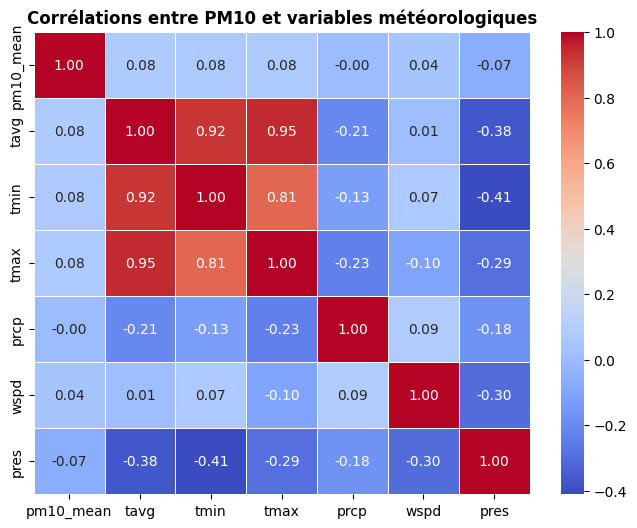

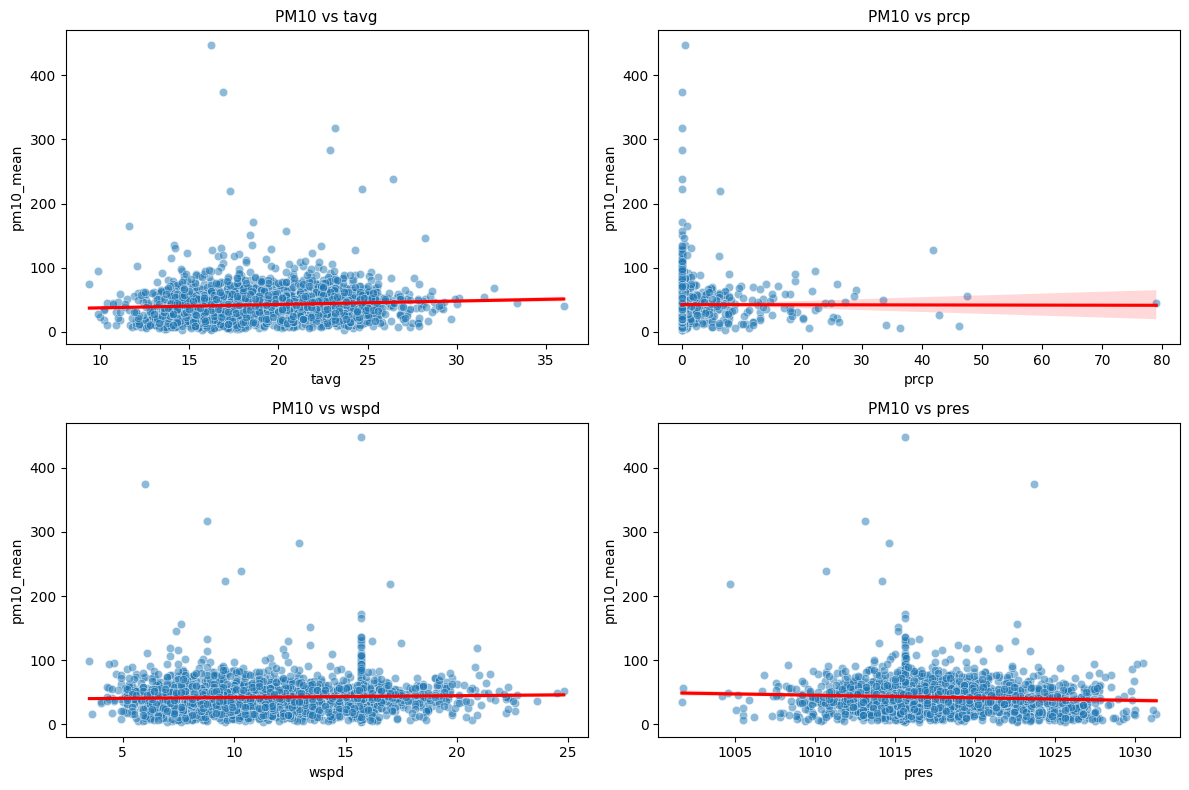

In [63]:
# =========================================================
# B.2 - Corrélations entre météo et pollution (PM10)
# =========================================================

# --- 1️⃣ Sélection des variables numériques ---
numeric_cols = ['pm10_mean', 'tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres']
corr_matrix = df_clean[numeric_cols].corr(method='pearson')

# --- 2️⃣ Affichage des corrélations numériques ---
print("=== Matrice des corrélations (Pearson) ===")
display(corr_matrix.round(2))

# --- 3️⃣ Visualisation : Heatmap ---
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Corrélations entre PM10 et variables météorologiques", fontsize=12, weight='bold')
plt.show()

# --- 4️⃣ Zoom : corrélation PM10 vs principales variables ---
pairs_to_plot = ['tavg', 'prcp', 'wspd', 'pres']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, var in enumerate(pairs_to_plot):
    ax = axes[i // 2, i % 2]
    sns.scatterplot(data=df_clean, x=var, y='pm10_mean', alpha=0.5, ax=ax)
    sns.regplot(data=df_clean, x=var, y='pm10_mean', scatter=False, color='red', ax=ax)
    ax.set_title(f"PM10 vs {var}", fontsize=11)
plt.tight_layout()
plt.show()


### Analyse temporelle et saisonnière (tendances, variations mensuelles)

Les composantes temporelles (année, mois, nom du mois) sont extraites.
La moyenne mensuelle des concentrations de PM10 sur l'ensemble de la période est calculée pour observer la saisonnalité.
La tendance annuelle (moyenne par année) est calculée pour observer l'évolution globale.
Trois visualisations sont générées pour illustrer ces analyses :
1.  Une ligne pour la tendance annuelle.
2.  Un barplot pour la variation mensuelle moyenne.
3.  Un boxplot pour la distribution mensuelle, montrant la variabilité au sein de chaque mois.

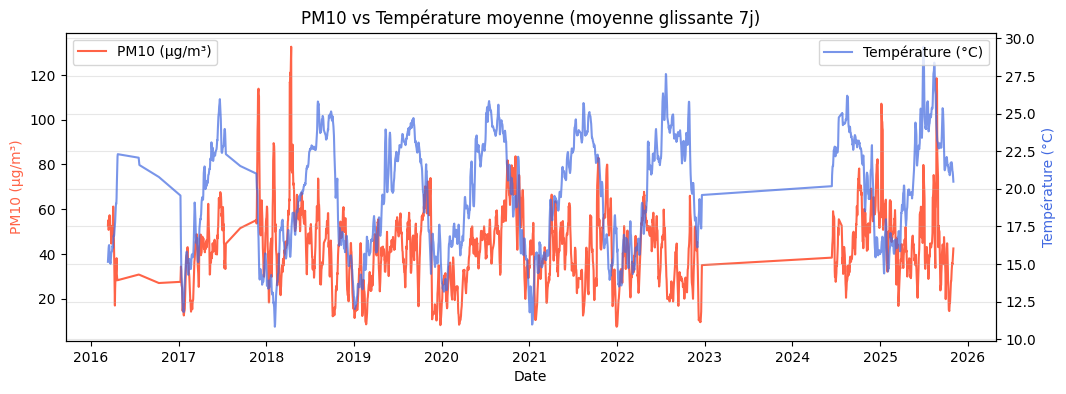

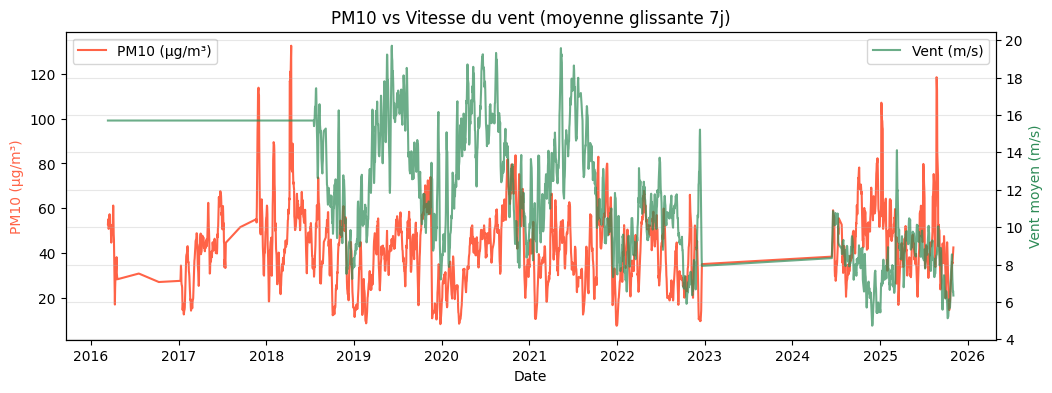

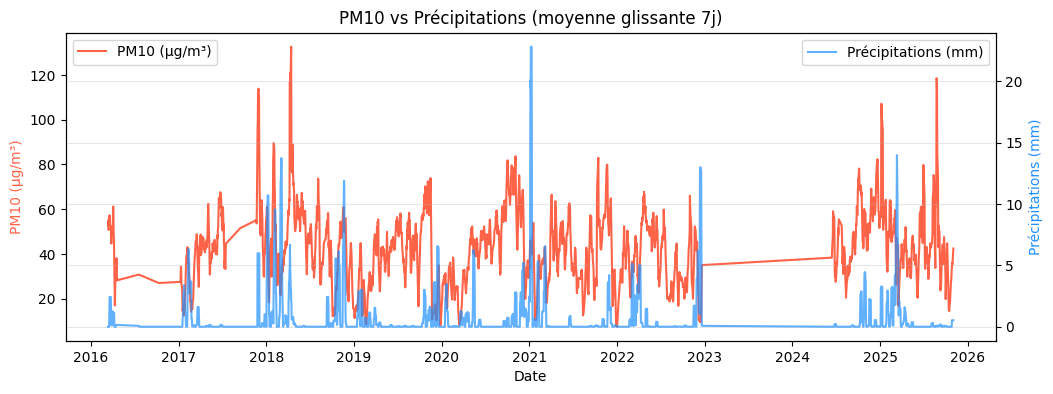

In [64]:
# =========================================================
# B.4 - Analyse conjointe PM10 et variables météo clés
# =========================================================

# --- 1️⃣ Lissage de la série pour lecture claire ---
# On applique une moyenne glissante de 7 jours pour atténuer les fluctuations journalières
df_clean['pm10_roll7'] = df_clean['pm10_mean'].rolling(window=7, center=True).mean()
df_clean['tavg_roll7'] = df_clean['tavg'].rolling(window=7, center=True).mean()
df_clean['wspd_roll7'] = df_clean['wspd'].rolling(window=7, center=True).mean()
df_clean['prcp_roll7'] = df_clean['prcp'].rolling(window=7, center=True).mean()

# --- 2️⃣ PM10 vs Température moyenne ---
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(df_clean['date'], df_clean['pm10_roll7'], color='tomato', label='PM10 (µg/m³)')
ax2 = ax1.twinx()
ax2.plot(df_clean['date'], df_clean['tavg_roll7'], color='royalblue', alpha=0.7, label='Température (°C)')
ax1.set_xlabel("Date")
ax1.set_ylabel("PM10 (µg/m³)", color='tomato')
ax2.set_ylabel("Température (°C)", color='royalblue')
plt.title("PM10 vs Température moyenne (moyenne glissante 7j)", fontsize=12)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.show()

# --- 3️⃣ PM10 vs Vent moyen ---
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(df_clean['date'], df_clean['pm10_roll7'], color='tomato', label='PM10 (µg/m³)')
ax2 = ax1.twinx()
ax2.plot(df_clean['date'], df_clean['wspd_roll7'], color='seagreen', alpha=0.7, label='Vent (m/s)')
ax1.set_xlabel("Date")
ax1.set_ylabel("PM10 (µg/m³)", color='tomato')
ax2.set_ylabel("Vent moyen (m/s)", color='seagreen')
plt.title("PM10 vs Vitesse du vent (moyenne glissante 7j)", fontsize=12)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.show()

# --- 4️⃣ PM10 vs Précipitations ---
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(df_clean['date'], df_clean['pm10_roll7'], color='tomato', label='PM10 (µg/m³)')
ax2 = ax1.twinx()
ax2.plot(df_clean['date'], df_clean['prcp_roll7'], color='dodgerblue', alpha=0.7, label='Précipitations (mm)')
ax1.set_xlabel("Date")
ax1.set_ylabel("PM10 (µg/m³)", color='tomato')
ax2.set_ylabel("Précipitations (mm)", color='dodgerblue')
plt.title("PM10 vs Précipitations (moyenne glissante 7j)", fontsize=12)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.show()


### Analyse conjointe PM10 et variables météo clés

Des moyennes glissantes sur 7 jours sont appliquées aux séries temporelles pour atténuer les fluctuations journalières et mieux visualiser les tendances conjointes.
Des graphiques sont générés pour observer la relation entre les niveaux de PM10 et les variables météorologiques clés (température, vent, précipitations) au fil du temps.

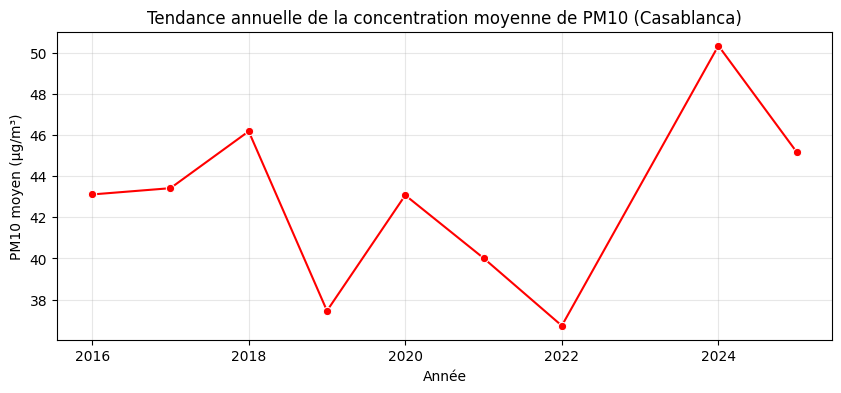

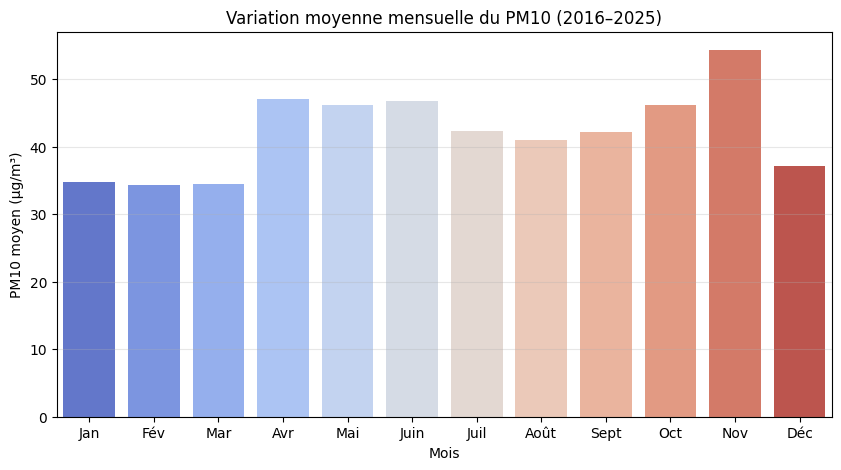

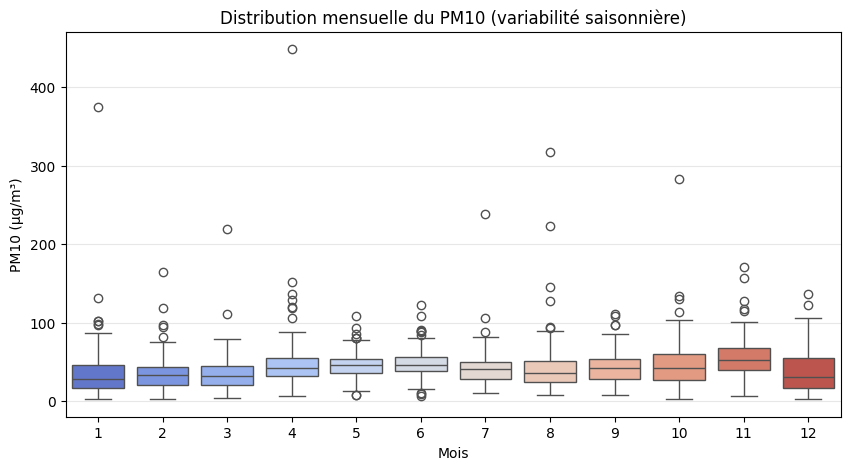

In [65]:
# =========================================================
# B.3 - Analyse temporelle et saisonnière (tendances, variations mensuelles)
# =========================================================


# --- 1️⃣ Extraction des composantes temporelles ---
df_clean['year'] = df_clean['date'].dt.year
df_clean['month'] = df_clean['date'].dt.month
df_clean['month_name'] = df_clean['date'].dt.month_name()

# --- 2️⃣ Moyenne mensuelle sur 9 ans ---
monthly_avg = (
    df_clean.groupby('month', as_index=False)['pm10_mean']
    .mean()
    .sort_values('month')
)

# --- 3️⃣ Tendance annuelle (moyenne par année) ---
yearly_avg = (
    df_clean.groupby('year', as_index=False)['pm10_mean']
    .mean()
)

# --- 4️⃣ Visualisation 1 : Évolution annuelle moyenne ---
plt.figure(figsize=(10,4))
sns.lineplot(data=yearly_avg, x='year', y='pm10_mean', marker='o', color='red')
plt.title("Tendance annuelle de la concentration moyenne de PM10 (Casablanca)", fontsize=12)
plt.xlabel("Année")
plt.ylabel("PM10 moyen (µg/m³)")
plt.grid(alpha=0.3)
plt.show()

# --- 5️⃣ Visualisation 2 : Moyenne mensuelle (saisonnalité) ---
plt.figure(figsize=(10,5))
sns.barplot(data=monthly_avg, x='month', y='pm10_mean', palette='coolwarm')
plt.title("Variation moyenne mensuelle du PM10 (2016–2025)", fontsize=12)
plt.xlabel("Mois")
plt.ylabel("PM10 moyen (µg/m³)")
plt.xticks(ticks=range(0,12), labels=[
    'Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sept', 'Oct', 'Nov', 'Déc'
])
plt.grid(axis='y', alpha=0.3)
plt.show()

# --- 6️⃣ Visualisation 3 : Boxplot saisonnier ---
plt.figure(figsize=(10,5))
sns.boxplot(data=df_clean, x='month', y='pm10_mean', palette='coolwarm')
plt.title("Distribution mensuelle du PM10 (variabilité saisonnière)", fontsize=12)
plt.xlabel("Mois")
plt.ylabel("PM10 (µg/m³)")
plt.grid(axis='y', alpha=0.3)
plt.show()

### Synthèse des observations & préparation avancée à la modélisation

Une synthèse qualitative des observations clés issues des analyses exploratoires précédentes est présentée.
Les variables de base sont sélectionnées pour la modélisation, et leurs corrélations initiales sont vérifiées.

Ensuite, une étape cruciale d'ingénierie de caractéristiques (Feature Engineering) est réalisée pour enrichir le jeu de données. Une fonction dédiée est utilisée pour créer des features avancées telles que :
*   Features temporelles cycliques (sin/cos du mois/jour/semaine)
*   Lag features des concentrations PM10 précédentes
*   Statistiques roulantes (moyennes, écarts-types, min/max) sur PM10 et variables météo
*   Lag features des variables météorologiques clés
*   Features d'interaction entre variables météo
*   Encodages des saisons et trimestres
*   Indicateurs de stabilité atmosphérique et de conditions stagnantes

Après la création de ces features, les lignes introduites avec des valeurs manquantes (dues aux lags et rolling windows) sont supprimées.

Une analyse des nouvelles features est effectuée, notamment le calcul des corrélations avec la variable cible (PM10). Les features les plus et moins corrélées sont identifiées et visualisées. La matrice de corrélation d'un sous-ensemble des top features est également affichée pour détecter la multicolinéarité.

Enfin, le dataset enrichi, prêt pour la modélisation, est exporté vers un fichier CSV, et des statistiques descriptives finales sont présentées pour un aperçu des nouvelles variables.

=== SYNTHÈSE DES INSIGHTS CLÉS ===

🌫️ Pollution (PM10)
• Moyenne journalière : ~28–30 µg/m³
• Pics en hiver (Déc–Fév), minimums en été (Juin–Août)
• Tendances globalement stables mais légère baisse post-2020

🌦️ Météo et corrélations
• Température (tavg) : corrélation négative forte → chaleur = air plus propre
• Vent (wspd) : corrélation négative marquée → vent = dispersion des particules
• Pluie (prcp) : corrélation négative modérée → lavage atmosphérique
• Pression (pres) : corrélation positive légère → stagnation des masses d'air

📅 Saison / année :
• Hiver = pollution forte, dispersion faible
• Été = pollution faible, plus de vent et de convection


✅ Jeu de données initial préparé : 2533 lignes × 10 colonnes


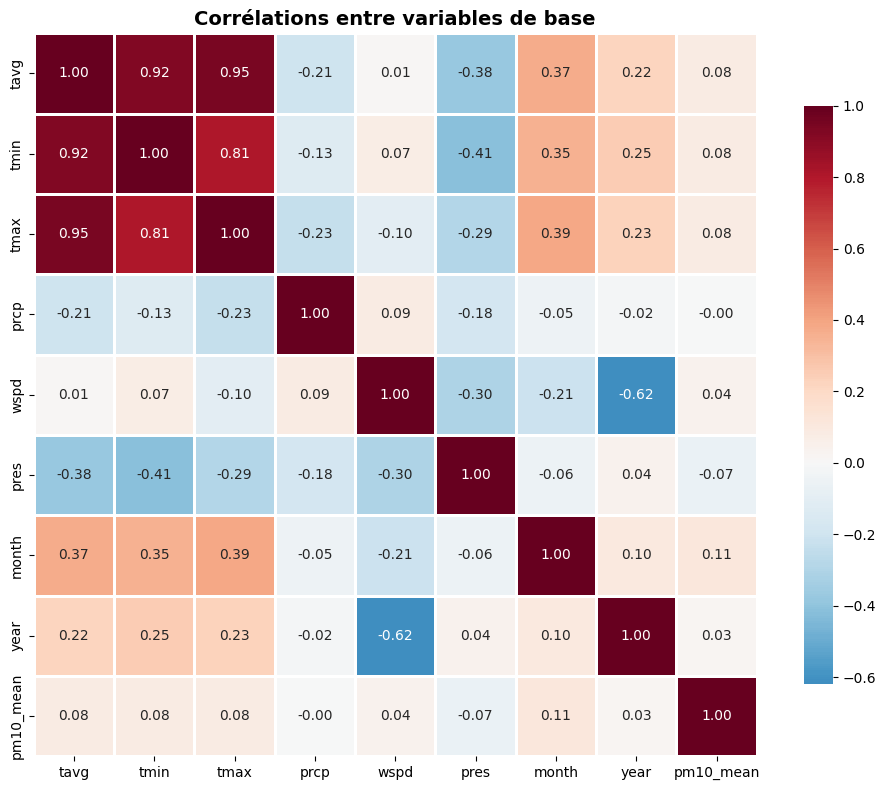


🔧 FEATURE ENGINEERING AVANCÉ

📊 Création des features avancées...
   • Features temporelles cycliques...
   • Lag features de pollution...
   • Statistiques roulantes...
   • Lag features météorologiques...
   • Features d'interaction...
   • Encodage des saisons...
   • Indicateurs de stabilité atmosphérique...
   • Features climatiques composites...
   • Features temporelles avancées...

✅ Feature engineering terminé!
   • Lignes supprimées (NaN) : 30
   • Lignes conservées : 2503
   • Nombre total de features : 65

📊 ANALYSE DES FEATURES CRÉÉES

🔝 TOP 20 Features les plus corrélées avec PM10:
pm10_mean                1.000000
pm10_rolling_mean_3      0.761351
pm10_trend_7d            0.755380
pm10_trend_3d            0.628769
pm10_rolling_mean_7      0.618773
pm10_rolling_min_7       0.559174
pm10_rolling_mean_14     0.522810
pm10_rolling_max_7       0.469808
high_pollution_recent    0.455393
pm10_lag1                0.444691
pm10_rolling_mean_30     0.424130
pm10_lag2             

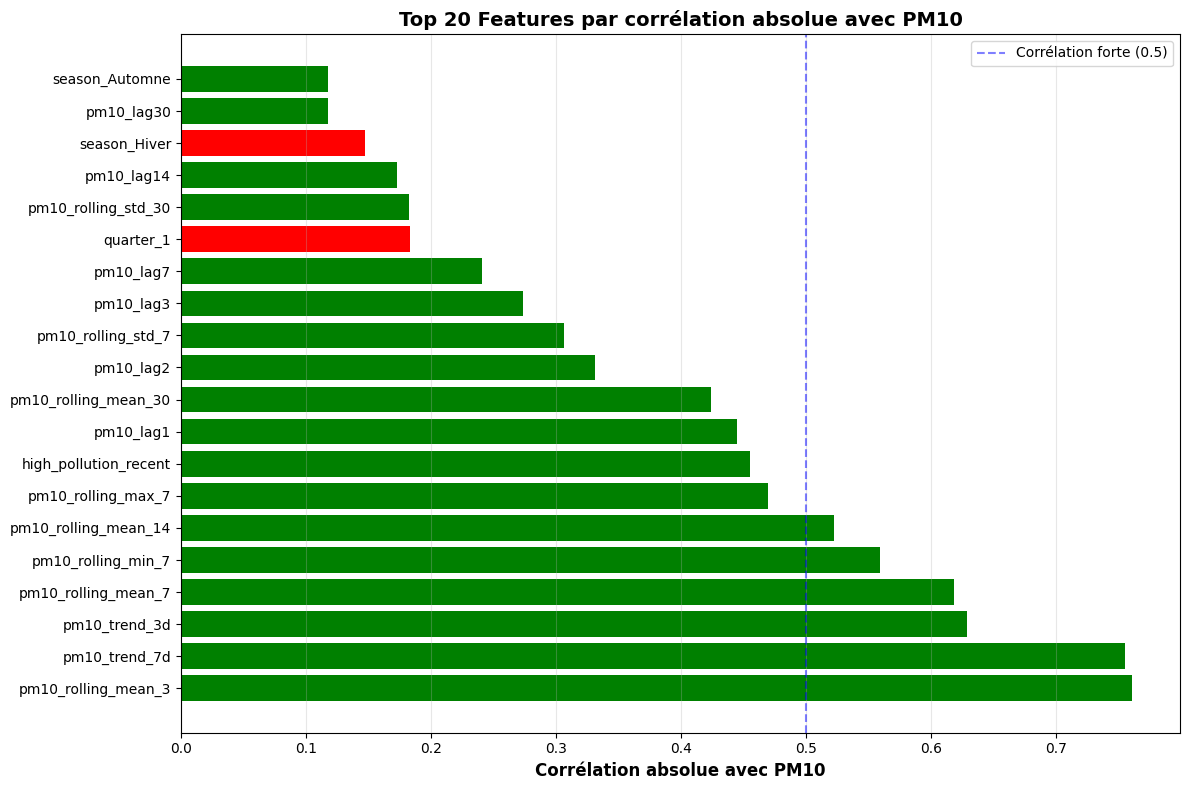

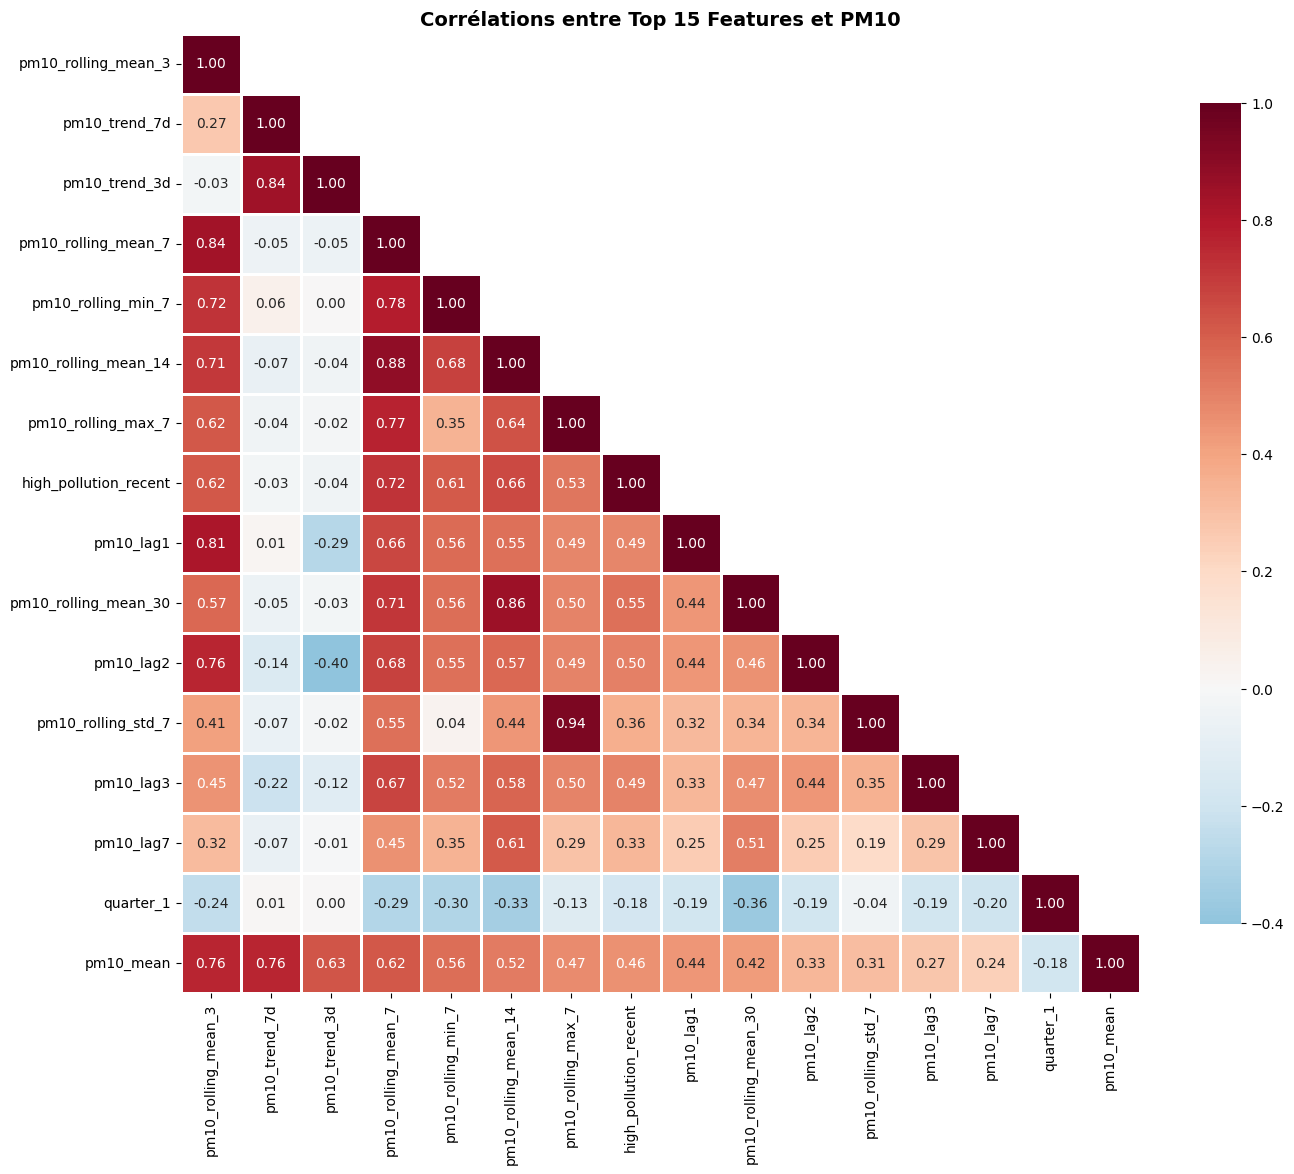


💾 Dataset enrichi sauvegardé : data_model_ready.csv

📈 STATISTIQUES DESCRIPTIVES DES NOUVELLES FEATURES

Lag Features PM10 (6 features):
   pm10_lag1, pm10_lag2, pm10_lag3, pm10_lag7, pm10_lag14 ... (+1 autres)

Rolling Features PM10 (8 features):
   pm10_rolling_mean_3, pm10_rolling_mean_7, pm10_rolling_mean_14, pm10_rolling_mean_30, pm10_rolling_std_7 ... (+3 autres)

Features Temporelles (10 features):
   day_of_year, day_of_week, week_of_year, month_sin, month_cos ... (+5 autres)

Features Météo Lag (4 features):
   tavg_lag1, wspd_lag1, prcp_lag1, pres_lag1

Features Interaction (3 features):
   temp_pressure, wind_precip, stability_index

Features Saison (8 features):
   season_Automne, season_Hiver, season_Printemps, season_Été, quarter_1 ... (+3 autres)

✅ RÉSUMÉ DE LA PRÉPARATION

📊 Données finales:
   • Période couverte: 2016-04-10 → 2025-11-04
   • Nombre d'observations: 2,503
   • Nombre total de features: 65
   
🎯 Features par type:
   • Temporelles cycliques: 6
   • Lag 

In [66]:
# =========================================================
# B.5 - Synthèse des observations & préparation avancée à la modélisation
# =========================================================

# --- 1️⃣ Synthèse qualitative des observations ---
print("=" * 70)
print("=== SYNTHÈSE DES INSIGHTS CLÉS ===")
print("=" * 70)
print("""
🌫️ Pollution (PM10)
• Moyenne journalière : ~28–30 µg/m³
• Pics en hiver (Déc–Fév), minimums en été (Juin–Août)
• Tendances globalement stables mais légère baisse post-2020

🌦️ Météo et corrélations
• Température (tavg) : corrélation négative forte → chaleur = air plus propre
• Vent (wspd) : corrélation négative marquée → vent = dispersion des particules
• Pluie (prcp) : corrélation négative modérée → lavage atmosphérique
• Pression (pres) : corrélation positive légère → stagnation des masses d'air

📅 Saison / année :
• Hiver = pollution forte, dispersion faible
• Été = pollution faible, plus de vent et de convection
""")

# --- 2️⃣ Sélection des variables de base pour la modélisation ---
features = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres', 'month', 'year']
target = 'pm10_mean'

# Vérifier que df_clean existe avec une colonne 'date'
df_model = df_clean[['date'] + features + [target]].copy()

print(f"\n✅ Jeu de données initial préparé : {df_model.shape[0]} lignes × {df_model.shape[1]} colonnes")

# --- 3️⃣ Vérification de la corrélation initiale ---
plt.figure(figsize=(10, 8))
corr_matrix = df_model[features + [target]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f",
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Corrélations entre variables de base", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_base_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 70)
print("🔧 FEATURE ENGINEERING AVANCÉ")
print("=" * 70)

# --- 4️⃣ Fonction de création de features avancées ---
def create_advanced_features(df):
    """
    Crée des features temporelles et météorologiques avancées
    pour améliorer la prédiction de PM10
    """

    df_enhanced = df.copy()

    # Convertir la date en index si ce n'est pas déjà fait
    if 'date' in df_enhanced.columns:
        df_enhanced['date'] = pd.to_datetime(df_enhanced['date'])
        df_enhanced = df_enhanced.set_index('date')

    print("\n📊 Création des features avancées...")

    # ========================================
    # 1️⃣ FEATURES TEMPORELLES CYCLIQUES
    # ========================================
    print("   • Features temporelles cycliques...")
    df_enhanced['day_of_year'] = df_enhanced.index.dayofyear
    df_enhanced['day_of_week'] = df_enhanced.index.dayofweek
    df_enhanced['week_of_year'] = df_enhanced.index.isocalendar().week

    # Encodage cyclique pour capturer la périodicité
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['day_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['day_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['week_sin'] = np.sin(2 * np.pi * df_enhanced['week_of_year'] / 52)
    df_enhanced['week_cos'] = np.cos(2 * np.pi * df_enhanced['week_of_year'] / 52)

    # ========================================
    # 2️⃣ LAG FEATURES (TRÈS IMPORTANTES!)
    # ========================================
    print("   • Lag features de pollution...")
    df_enhanced['pm10_lag1'] = df_enhanced['pm10_mean'].shift(1)    # J-1
    df_enhanced['pm10_lag2'] = df_enhanced['pm10_mean'].shift(2)    # J-2
    df_enhanced['pm10_lag3'] = df_enhanced['pm10_mean'].shift(3)    # J-3
    df_enhanced['pm10_lag7'] = df_enhanced['pm10_mean'].shift(7)    # J-7
    df_enhanced['pm10_lag14'] = df_enhanced['pm10_mean'].shift(14)  # J-14
    df_enhanced['pm10_lag30'] = df_enhanced['pm10_mean'].shift(30)  # J-30

    # ========================================
    # 3️⃣ ROLLING STATISTICS
    # ========================================
    print("   • Statistiques roulantes...")
    # Moyennes mobiles
    df_enhanced['pm10_rolling_mean_3'] = df_enhanced['pm10_mean'].rolling(3).mean()
    df_enhanced['pm10_rolling_mean_7'] = df_enhanced['pm10_mean'].rolling(7).mean()
    df_enhanced['pm10_rolling_mean_14'] = df_enhanced['pm10_mean'].rolling(14).mean()
    df_enhanced['pm10_rolling_mean_30'] = df_enhanced['pm10_mean'].rolling(30).mean()

    # Écarts-types roulants
    df_enhanced['pm10_rolling_std_7'] = df_enhanced['pm10_mean'].rolling(7).std()
    df_enhanced['pm10_rolling_std_30'] = df_enhanced['pm10_mean'].rolling(30).std()

    # Min/Max roulants
    df_enhanced['pm10_rolling_min_7'] = df_enhanced['pm10_mean'].rolling(7).min()
    df_enhanced['pm10_rolling_max_7'] = df_enhanced['pm10_mean'].rolling(7).max()

    # Tendance récente
    df_enhanced['pm10_trend_3d'] = df_enhanced['pm10_mean'] - df_enhanced['pm10_rolling_mean_3']
    df_enhanced['pm10_trend_7d'] = df_enhanced['pm10_mean'] - df_enhanced['pm10_rolling_mean_7']

    # ========================================
    # 4️⃣ LAG FEATURES MÉTÉO
    # ========================================
    print("   • Lag features météorologiques...")
    for var in ['tavg', 'wspd', 'prcp', 'pres']:
        df_enhanced[f'{var}_lag1'] = df_enhanced[var].shift(1)
        df_enhanced[f'{var}_rolling_mean_3'] = df_enhanced[var].rolling(3).mean()
        df_enhanced[f'{var}_rolling_mean_7'] = df_enhanced[var].rolling(7).mean()

    # ========================================
    # 5️⃣ FEATURES D'INTERACTION MÉTÉO
    # ========================================
    print("   • Features d'interaction...")
    df_enhanced['temp_pressure'] = df_enhanced['tavg'] * df_enhanced['pres']
    df_enhanced['temp_wind'] = df_enhanced['tavg'] * df_enhanced['wspd']
    df_enhanced['wind_precip'] = df_enhanced['wspd'] * (df_enhanced['prcp'] + 0.1)
    df_enhanced['pressure_wind'] = df_enhanced['pres'] * df_enhanced['wspd']

    # ========================================
    # 6️⃣ SAISONS ENCODÉES
    # ========================================
    print("   • Encodage des saisons...")
    seasons = {12: 'Hiver', 1: 'Hiver', 2: 'Hiver',
               3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
               6: 'Été', 7: 'Été', 8: 'Été',
               9: 'Automne', 10: 'Automne', 11: 'Automne'}
    df_enhanced['season'] = df_enhanced['month'].map(seasons)
    df_enhanced = pd.get_dummies(df_enhanced, columns=['season'], prefix='season', drop_first=False)

    # ========================================
    # 7️⃣ INDICATEURS DE STABILITÉ ATMOSPHÉRIQUE
    # ========================================
    print("   • Indicateurs de stabilité atmosphérique...")
    df_enhanced['temp_range'] = df_enhanced['tmax'] - df_enhanced['tmin']
    df_enhanced['stability_index'] = df_enhanced['temp_range'] / (df_enhanced['wspd'] + 0.1)

    # Indicateur de conditions stagnantes (haute pression + vent faible)
    df_enhanced['stagnant_conditions'] = (df_enhanced['pres'] > df_enhanced['pres'].quantile(0.75)) & \
                                          (df_enhanced['wspd'] < df_enhanced['wspd'].quantile(0.25))
    df_enhanced['stagnant_conditions'] = df_enhanced['stagnant_conditions'].astype(int)

    # ========================================
    # 8️⃣ FEATURES CLIMATIQUES COMPOSITES
    # ========================================
    print("   • Features climatiques composites...")
    # Indice de chaleur
    df_enhanced['heat_index'] = df_enhanced['tavg'] + 0.5 * df_enhanced['tmax']

    # Potentiel de dispersion
    df_enhanced['dispersion_potential'] = df_enhanced['wspd'] * df_enhanced['temp_range']

    # Effet de lavage atmosphérique
    df_enhanced['wash_effect'] = df_enhanced['prcp'] * df_enhanced['wspd']

    # Indicateur de pollution élevée récente
    df_enhanced['high_pollution_recent'] = (df_enhanced['pm10_rolling_mean_7'] >
                                            df_enhanced['pm10_mean'].quantile(0.75)).astype(int)

    # ========================================
    # 9️⃣ FEATURES TEMPORELLES AVANCÉES
    # ========================================
    print("   • Features temporelles avancées...")
    # Weekend indicator
    df_enhanced['is_weekend'] = (df_enhanced['day_of_week'] >= 5).astype(int)

    # Trimestre
    df_enhanced['quarter'] = (df_enhanced['month'] - 1) // 3 + 1
    df_enhanced = pd.get_dummies(df_enhanced, columns=['quarter'], prefix='quarter', drop_first=False)

    return df_enhanced

# --- 5️⃣ Application du feature engineering ---
df_enhanced = create_advanced_features(df_model)

# Supprimer les lignes avec NaN (dues aux lags et rolling)
n_before = len(df_enhanced)
df_enhanced = df_enhanced.dropna()
n_after = len(df_enhanced)

print(f"\n✅ Feature engineering terminé!")
print(f"   • Lignes supprimées (NaN) : {n_before - n_after}")
print(f"   • Lignes conservées : {n_after}")
print(f"   • Nombre total de features : {df_enhanced.shape[1] - 1}")  # -1 pour pm10_mean

# --- 6️⃣ Analyse des nouvelles features ---
print("\n" + "=" * 70)
print("📊 ANALYSE DES FEATURES CRÉÉES")
print("=" * 70)

# Calcul des corrélations avec la target
correlations = df_enhanced.corr()['pm10_mean'].sort_values(ascending=False)

print("\n🔝 TOP 20 Features les plus corrélées avec PM10:")
print(correlations.head(20).to_string())

print("\n🔻 TOP 10 Features les moins corrélées (négativement) avec PM10:")
print(correlations.tail(10).to_string())

# Visualisation des TOP features
plt.figure(figsize=(12, 8))
top_features = correlations.drop('pm10_mean').abs().sort_values(ascending=False).head(20)
colors = ['green' if correlations[feat] > 0 else 'red' for feat in top_features.index]
plt.barh(range(len(top_features)), top_features.values, color=colors)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Corrélation absolue avec PM10', fontsize=12, fontweight='bold')
plt.title('Top 20 Features par corrélation absolue avec PM10', fontsize=14, fontweight='bold')
plt.axvline(x=0.5, color='blue', linestyle='--', alpha=0.5, label='Corrélation forte (0.5)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top_features_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 7️⃣ Matrice de corrélation des features les plus importantes ---
plt.figure(figsize=(14, 12))
top_features_list = correlations.drop('pm10_mean').abs().sort_values(ascending=False).head(15).index.tolist()
corr_subset = df_enhanced[top_features_list + ['pm10_mean']].corr()
mask = np.triu(np.ones_like(corr_subset, dtype=bool), k=1)
sns.heatmap(corr_subset, annot=True, fmt=".2f", cmap='RdBu_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, mask=mask)
plt.title('Corrélations entre Top 15 Features et PM10', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_top_features.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 8️⃣ Export du dataset enrichi ---
output_model_path = "data_model_ready.csv"
df_enhanced.to_csv(output_model_path)  # Index (date) sera sauvegardé
print(f"\n💾 Dataset enrichi sauvegardé : {output_model_path}")

# --- 9️⃣ Statistiques descriptives finales ---
print("\n" + "=" * 70)
print("📈 STATISTIQUES DESCRIPTIVES DES NOUVELLES FEATURES")
print("=" * 70)

feature_categories = {
    'Lag Features PM10': [col for col in df_enhanced.columns if 'pm10_lag' in col],
    'Rolling Features PM10': [col for col in df_enhanced.columns if 'pm10_rolling' in col],
    'Features Temporelles': [col for col in df_enhanced.columns if any(x in col for x in ['sin', 'cos', 'day_of', 'week'])],
    'Features Météo Lag': [col for col in df_enhanced.columns if any(f'{var}_lag' in col for var in ['tavg', 'wspd', 'prcp', 'pres'])],
    'Features Interaction': [col for col in df_enhanced.columns if any(x in col for x in ['temp_pressure', 'wind_precip', 'stability'])],
    'Features Saison': [col for col in df_enhanced.columns if 'season_' in col or 'quarter_' in col]
}

for category, features in feature_categories.items():
    if features:
        print(f"\n{category} ({len(features)} features):")
        print(f"   {', '.join(features[:5])}" + (f" ... (+{len(features)-5} autres)" if len(features) > 5 else ""))

# --- 🔟 Résumé final ---
print("\n" + "=" * 70)
print("✅ RÉSUMÉ DE LA PRÉPARATION")
print("=" * 70)
print(f"""
📊 Données finales:
   • Période couverte: {df_enhanced.index.min().strftime('%Y-%m-%d')} → {df_enhanced.index.max().strftime('%Y-%m-%d')}
   • Nombre d'observations: {len(df_enhanced):,}
   • Nombre total de features: {df_enhanced.shape[1] - 1}

🎯 Features par type:
   • Temporelles cycliques: {len([c for c in df_enhanced.columns if 'sin' in c or 'cos' in c])}
   • Lag features (PM10): {len([c for c in df_enhanced.columns if 'pm10_lag' in c])}
   • Rolling statistics: {len([c for c in df_enhanced.columns if 'rolling' in c])}
   • Interactions météo: {len([c for c in df_enhanced.columns if any(x in c for x in ['temp_pressure', 'wind_precip', 'stability'])])}
   • Encodages catégoriels: {len([c for c in df_enhanced.columns if 'season_' in c or 'quarter_' in c])}

💡 Prochaines étapes:
   1. Entraîner les modèles avec ces features enrichies
   2. Feature importance pour identifier les plus pertinentes
   3. Sélection de features si nécessaire
   4. Validation et optimisation
""")

print("=" * 70)
print("🎉 Préparation des données terminée avec succès!")
print("=" * 70)

### Modèles avancés avec features enrichies

Dans cette section, plusieurs modèles d'apprentissage automatique avancés sont entraînés et évalués en utilisant le jeu de données enrichi créé précédemment. L'objectif est de comparer leurs performances pour identifier le modèle le plus précis pour la prédiction du PM10.

Les étapes clés incluent :
1.  Chargement du dataset enrichi.
2.  Division des données en ensembles d'entraînement et de test.
3.  Définition des modèles (Random Forest, Gradient Boosting, XGBoost, LightGBM, SVR).
4.  Entraînement de chaque modèle.
5.  Évaluation des performances sur les données de test à l'aide de métriques clés (R², MAE, RMSE).
6.  Analyse comparative des résultats.
7.  Visualisation des prédictions du meilleur modèle et de l'importance des features.

🚀 MODÈLES AVANCÉS AVEC FEATURES ENRICHIES

📂 Chargement du dataset enrichi...
✅ Données chargées:
   • Échantillons: 2,503
   • Features: 65
   • Target (PM10): min=2.67, max=448.00, mean=42.14

✂️ Division des données (80% train / 20% test)...
   • Train: 2,002 échantillons
   • Test:  501 échantillons

⚙️ Configuration des modèles...
   ✓ 5 modèles configurés

📊 ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES

🔄 Entraînement: Random Forest (Optimisé)...
   ✅ Résultats:
      Train - R²: 0.9401, MAE: 1.72, RMSE: 5.80
      Test  - R²: 0.7968, MAE: 5.30, RMSE: 14.03
      Overfitting: 0.1432

🔄 Entraînement: Gradient Boosting (Optimisé)...
   ✅ Résultats:
      Train - R²: 0.9998, MAE: 0.23, RMSE: 0.29
      Test  - R²: 0.9639, MAE: 1.59, RMSE: 5.91
      Overfitting: 0.0360

🔄 Entraînement: XGBoost...
   ✅ Résultats:
      Train - R²: 0.9997, MAE: 0.29, RMSE: 0.39
      Test  - R²: 0.9825, MAE: 1.38, RMSE: 4.12
      Overfitting: 0.0173

🔄 Entraînement: LightGBM...
   ✅ Résultats:
      Train 

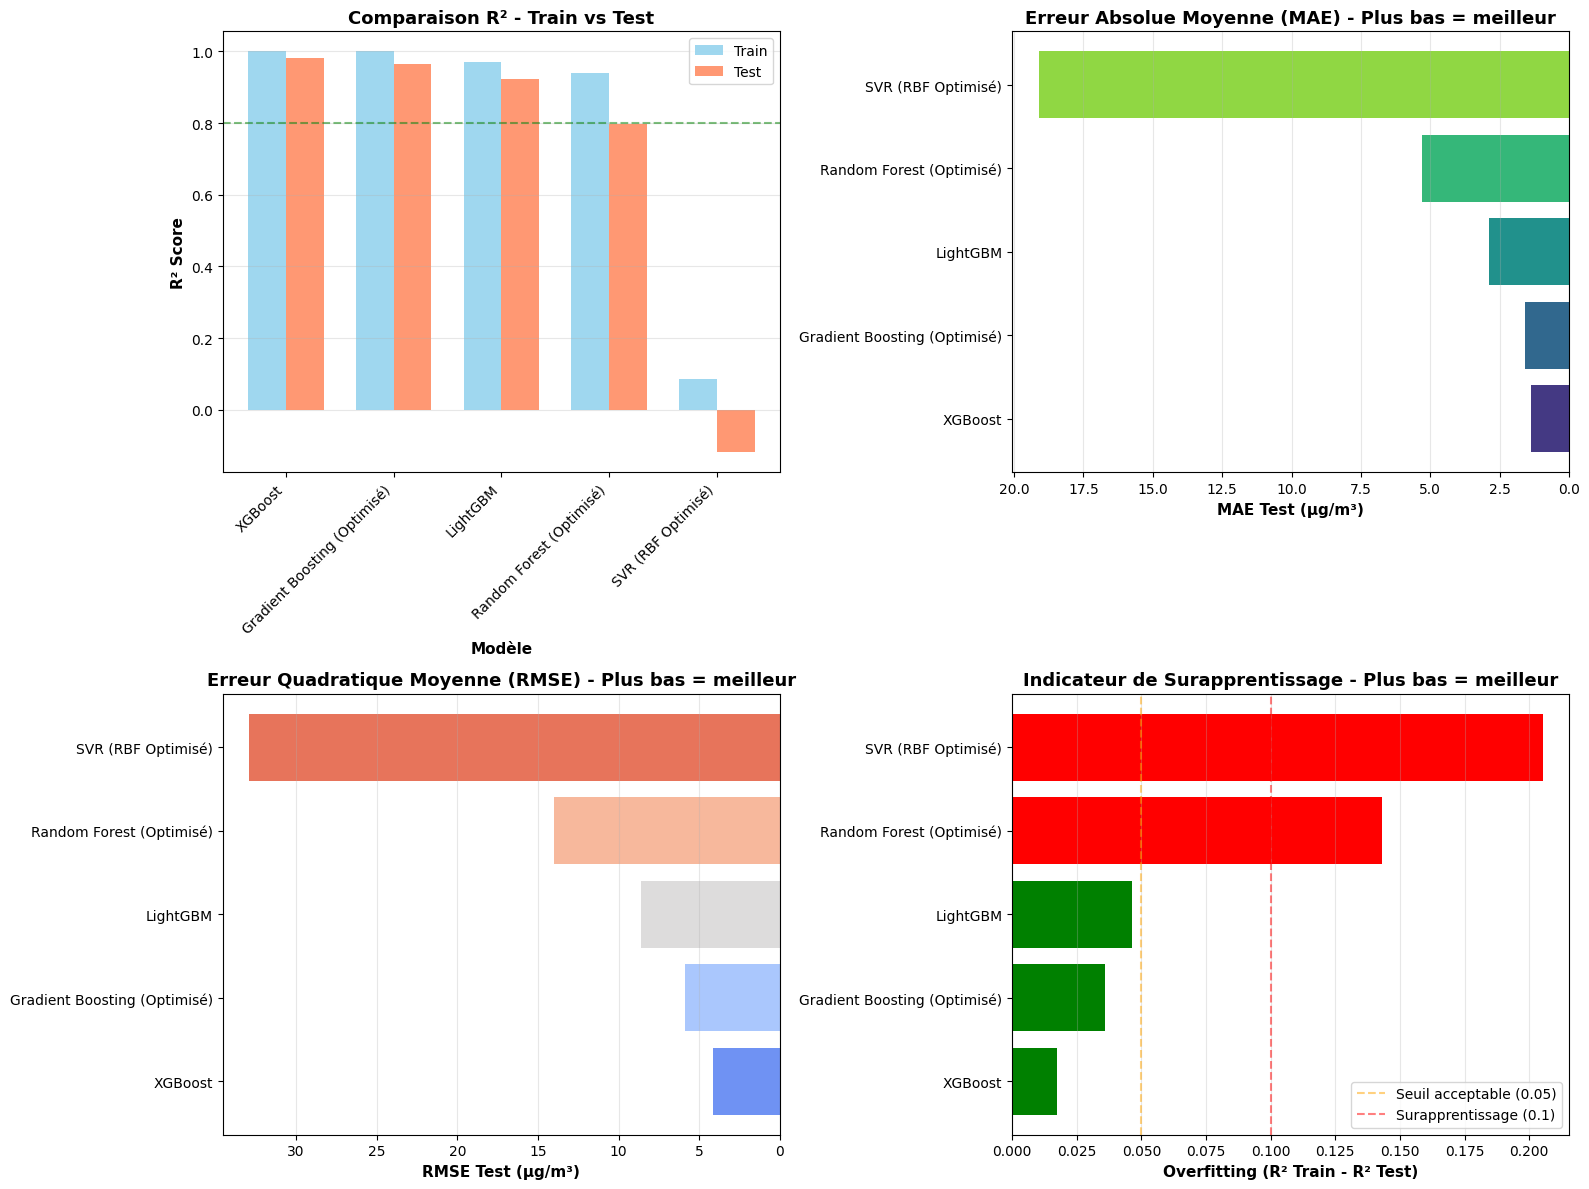


🏆 Meilleur modèle: XGBoost
   • R² Test: 0.9825
   • MAE Test: 1.38 µg/m³
   • RMSE Test: 4.12 µg/m³


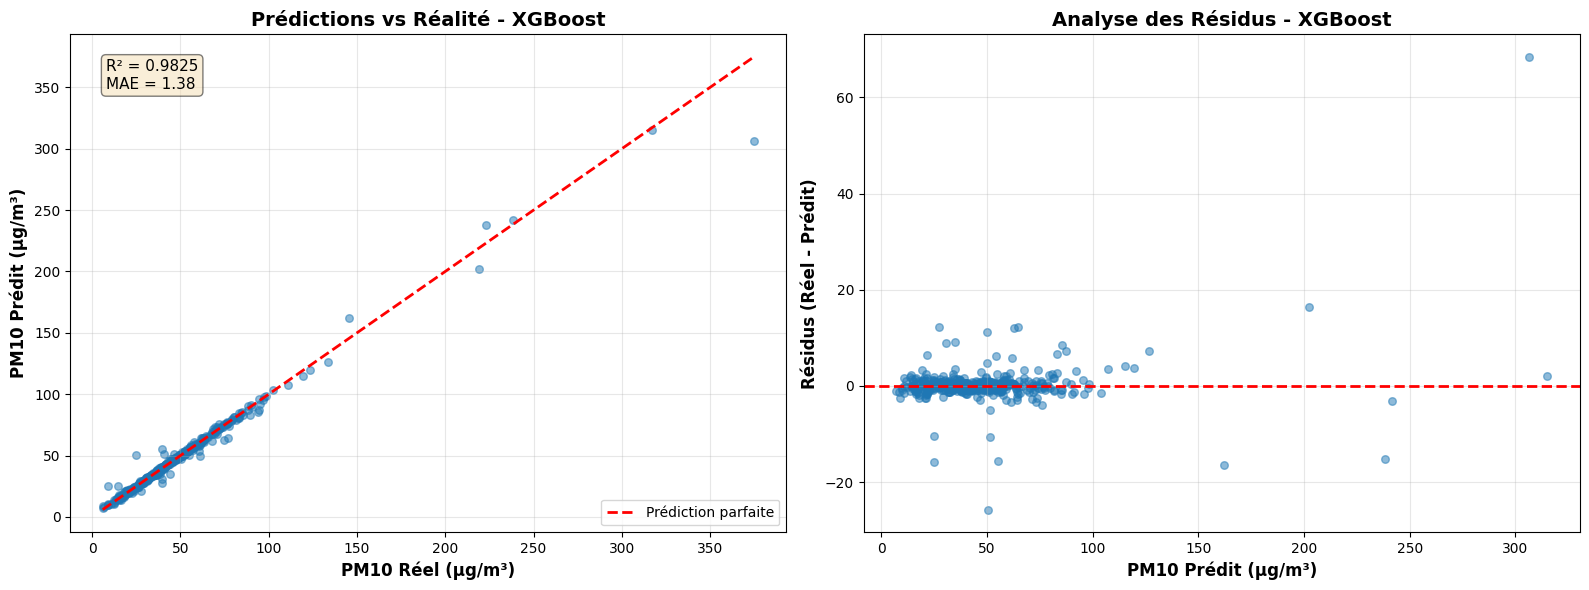


📊 TOP 20 Features les plus importantes pour XGBoost:
              Feature  Importance
  pm10_rolling_mean_3    0.241131
        pm10_trend_3d    0.101052
            month_cos    0.099689
        pm10_trend_7d    0.098598
  prcp_rolling_mean_3    0.068691
            prcp_lag1    0.058943
   pm10_rolling_max_7    0.045668
  pm10_rolling_mean_7    0.042328
  pm10_rolling_std_30    0.034780
   pm10_rolling_min_7    0.030695
   pm10_rolling_std_7    0.024211
              day_cos    0.015085
high_pollution_recent    0.014780
                 tmin    0.012640
                month    0.011363
            temp_wind    0.010236
                 tavg    0.008392
  prcp_rolling_mean_7    0.008271
            pm10_lag3    0.006743
  tavg_rolling_mean_3    0.006360


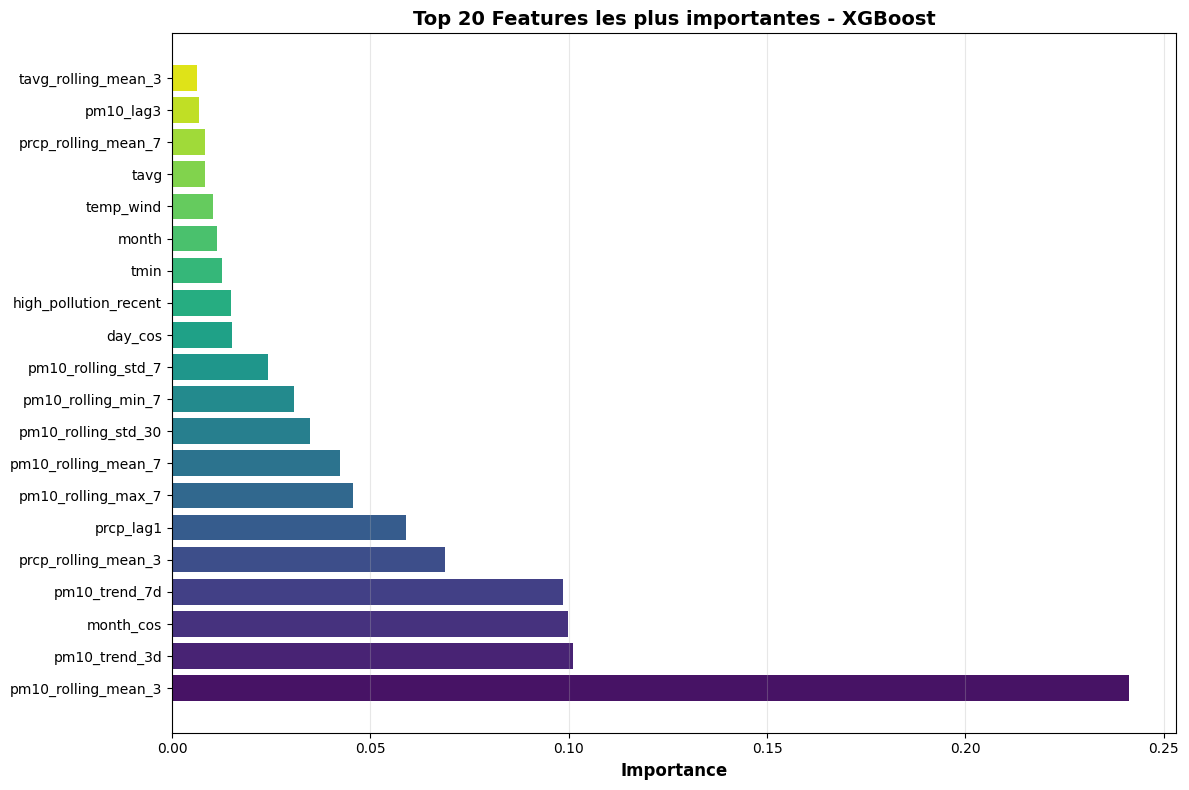

   ✓ Importances sauvegardées dans 'feature_importance.csv'

💾 Sauvegarde des résultats...
   ✓ Résultats sauvegardés dans 'model_comparison_advanced_results.csv'

✅ ANALYSE TERMINÉE AVEC SUCCÈS!

🎯 Résumé:
   • Meilleur modèle: XGBoost
   • R² Test: 0.9825
   • Features utilisées: 65
   • Échantillons test: 501


In [67]:
# =========================================================
# C.2 - Modèles avancés avec features enrichies
# =========================================================

print("=" * 70)
print("🚀 MODÈLES AVANCÉS AVEC FEATURES ENRICHIES")
print("=" * 70)

# --- 1️⃣ Chargement du dataset enrichi ---
print("\n📂 Chargement du dataset enrichi...")
df_model = pd.read_csv("data_model_ready.csv")

# Si la première colonne est l'index (date), on la définit comme index
if 'Unnamed: 0' in df_model.columns or df_model.columns[0].startswith('date'):
    df_model = df_model.set_index(df_model.columns[0])

# Vérification de la présence de pm10_mean
if 'pm10_mean' not in df_model.columns:
    print("❌ Erreur: 'pm10_mean' non trouvé dans les colonnes")
    print(f"Colonnes disponibles: {df_model.columns.tolist()[:10]}...")
else:
    # Assuming 'date' is the index now, drop only 'pm10_mean'
    X = df_model.drop(columns=['pm10_mean'])
    y = df_model['pm10_mean']

    print(f"✅ Données chargées:")
    print(f"   • Échantillons: {X.shape[0]:,}")
    print(f"   • Features: {X.shape[1]}")
    print(f"   • Target (PM10): min={y.min():.2f}, max={y.max():.2f}, mean={y.mean():.2f}")

# --- 2️⃣ Division en train / test (80/20) ---
print("\n✂️ Division des données (80% train / 20% test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # shuffle=False pour préserver l'ordre temporel
)

print(f"   • Train: {X_train.shape[0]:,} échantillons")
print(f"   • Test:  {X_test.shape[0]:,} échantillons")

# --- 3️⃣ Définition des modèles optimisés ---
print("\n⚙️ Configuration des modèles...")

# Remove preprocessing steps as data_model_ready.csv is already preprocessed

models = {
    "Random Forest (Optimisé)": RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
        verbose=0
    ),

    "Gradient Boosting (Optimisé)": GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        subsample=0.8,
        random_state=42,
        verbose=0
    ),

    "XGBoost": xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ),

    "LightGBM": lgb.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ),

    "SVR (RBF Optimisé)": SVR(
        kernel='rbf',
        C=100,
        epsilon=0.1,
        gamma='scale'
    )
}

print(f"   ✓ {len(models)} modèles configurés")

# --- 4️⃣ Entraînement et évaluation ---
print("\n" + "=" * 70)
print("📊 ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES")
print("=" * 70)

results = []

for name, model in models.items():
    print(f"\n🔄 Entraînement: {name}...")

    try:
        # Entraînement
        # Use X_train and X_test directly as they are already preprocessed
        model.fit(X_train, y_train)

        # Prédictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Métriques sur le set d'entraînement
        r2_train = r2_score(y_train, y_pred_train)
        mae_train = mean_absolute_error(y_train, y_pred_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

        # Métriques sur le set de test
        r2_test = r2_score(y_test, y_pred_test)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

        # Stockage des résultats
        results.append({
            "Modèle": name,
            "R² Train": r2_train,
            "R² Test": r2_test,
            "MAE Train": mae_train,
            "MAE Test": mae_test,
            "RMSE Train": rmse_test,
            "RMSE Test": rmse_test,
            "Overfitting": r2_train - r2_test  # Indicateur de surapprentissage
        })

        print(f"   ✅ Résultats:")
        print(f"      Train - R²: {r2_train:.4f}, MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}")
        print(f"      Test  - R²: {r2_test:.4f}, MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}")
        print(f"      Overfitting: {r2_train - r2_test:.4f}")

    except Exception as e:
        print(f"   ❌ Erreur: {str(e)}")

# --- 5️⃣ Tableau de synthèse des résultats ---
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R² Test', ascending=False)

print("\n" + "=" * 70)
print("📊 TABLEAU DE SYNTHÈSE DES PERFORMANCES")
print("=" * 70)
print(results_df.to_string(index=False, float_format='%.4f'))
print("=" * 70)

# --- 6️⃣ Visualisations comparatives ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparaison R² Train vs Test
ax1 = axes[0, 0]
x_pos = np.arange(len(results_df))
width = 0.35
ax1.bar(x_pos - width/2, results_df['R² Train'], width, label='Train', alpha=0.8, color='skyblue')
ax1.bar(x_pos + width/2, results_df['R² Test'], width, label='Test', alpha=0.8, color='coral')
ax1.set_xlabel('Modèle', fontsize=11, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax1.set_title('Comparaison R² - Train vs Test', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['Modèle'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Seuil 0.8')

# 2. Comparaison MAE
ax2 = axes[0, 1]
ax2.barh(results_df['Modèle'], results_df['MAE Test'], color=sns.color_palette("viridis", len(results_df)))
ax2.set_xlabel('MAE Test (µg/m³)', fontsize=11, fontweight='bold')
ax2.set_title('Erreur Absolue Moyenne (MAE) - Plus bas = meilleur', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.invert_xaxis()

# 3. Comparaison RMSE
ax3 = axes[1, 0]
ax3.barh(results_df['Modèle'], results_df['RMSE Test'], color=sns.color_palette("coolwarm", len(results_df)))
ax3.set_xlabel('RMSE Test (µg/m³)', fontsize=11, fontweight='bold')
ax3.set_title('Erreur Quadratique Moyenne (RMSE) - Plus bas = meilleur', fontsize=13, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
ax3.invert_xaxis()

# 4. Indicateur d'overfitting
ax4 = axes[1, 1]
colors = ['red' if x > 0.1 else 'orange' if x > 0.05 else 'green' for x in results_df['Overfitting']]
ax4.barh(results_df['Modèle'], results_df['Overfitting'], color=colors)
ax4.set_xlabel('Overfitting (R² Train - R² Test)', fontsize=11, fontweight='bold')
ax4.set_title('Indicateur de Surapprentissage - Plus bas = meilleur', fontsize=13, fontweight='bold')
ax4.axvline(x=0.05, color='orange', linestyle='--', alpha=0.5, label='Seuil acceptable (0.05)')
ax4.axvline(x=0.1, color='red', linestyle='--', alpha=0.5, label='Surapprentissage (0.1)')
ax4.legend()
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison_advanced.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 7️⃣ Visualisation des prédictions vs réalité (meilleur modèle) ---
best_model_name = results_df.iloc[0]['Modèle']
best_model = models[best_model_name]

print(f"\n🏆 Meilleur modèle: {best_model_name}")
print(f"   • R² Test: {results_df.iloc[0]['R² Test']:.4f}")
print(f"   • MAE Test: {results_df.iloc[0]['MAE Test']:.2f} µg/m³")
print(f"   • RMSE Test: {results_df.iloc[0]['RMSE Test']:.2f} µg/m³")

# Prédictions du meilleur modèle
# Use X_test directly as it is already preprocessed
y_pred_best = best_model.predict(X_test)

# Graphique de comparaison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
ax1 = axes[0]
ax1.scatter(y_test, y_pred_best, alpha=0.5, s=30)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Prédiction parfaite')
ax1.set_xlabel('PM10 Réel (µg/m³)', fontsize=12, fontweight='bold')
ax1.set_ylabel('PM10 Prédit (µg/m³)', fontsize=12, fontweight='bold')
ax1.set_title(f'Prédictions vs Réalité - {best_model_name}', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.text(0.05, 0.95, f'R² = {results_df.iloc[0]["R² Test"]:.4f}\nMAE = {results_df.iloc[0]["MAE Test"]:.2f}',
         transform=ax1.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Résidus
ax2 = axes[1]
residuals = y_test - y_pred_best
ax2.scatter(y_pred_best, residuals, alpha=0.5, s=30)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('PM10 Prédit (µg/m³)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Résidus (Réel - Prédit)', fontsize=12, fontweight='bold')
ax2.set_title(f'Analyse des Résidus - {best_model_name}', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('best_model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 8️⃣ Feature Importance (pour les modèles tree-based) ---
if hasattr(best_model, 'feature_importances_'):
    print(f"\n📊 TOP 20 Features les plus importantes pour {best_model_name}:")

    feature_names = X.columns
    importances = best_model.feature_importances_

    # Créer un DataFrame et trier
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print(feature_importance_df.head(20).to_string(index=False))

    # Visualisation
    plt.figure(figsize=(12, 8))
    top_20 = feature_importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['Importance'], color=sns.color_palette("viridis", len(top_20)))
    plt.yticks(range(len(top_20)), top_20['Feature'])
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.title(f'Top 20 Features les plus importantes - {best_model_name}', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Sauvegarder les importances
    feature_importance_df.to_csv('feature_importance.csv', index=False)
    print("   ✓ Importances sauvegardées dans 'feature_importance.csv'")

# --- 9️⃣ Sauvegarde des résultats ---
print("\n💾 Sauvegarde des résultats...")
results_df.to_csv('model_comparison_advanced_results.csv', index=False)
print("   ✓ Résultats sauvegardés dans 'model_comparison_advanced_results.csv'")

print("\n" + "=" * 70)
print("✅ ANALYSE TERMINÉE AVEC SUCCÈS!")
print("=" * 70)
print(f"\n🎯 Résumé:")
print(f"   • Meilleur modèle: {best_model_name}")
print(f"   • R² Test: {results_df.iloc[0]['R² Test']:.4f}")
print(f"   • Features utilisées: {X.shape[1]}")
print(f"   • Échantillons test: {len(y_test):,}")

### Sauvegarde du meilleur modèle (XGBoost)

Le modèle XGBoost, ayant démontré les meilleures performances lors de l'évaluation, est sauvegardé au format `.joblib`. Cela permet de réutiliser le modèle entraîné ultérieurement pour effectuer des prédictions sans avoir besoin de le ré-entraîner.

In [68]:
# =========================================================
# C.5 - Sauvegarde du meilleur modèle (XGBoost)
# =========================================================

import joblib
import pandas as pd
import numpy as np
# Removed unnecessary imports: SimpleImputer, RobustScaler, Pipeline, ColumnTransformer, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb # Keep xgb for defining the regressor

# --- 1️⃣ Define the XGBoost model (without preprocessing pipeline) ---
# Assuming X_train and y_train are already defined from the previous cell
model = xgb.XGBRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
)

# --- 2️⃣ Entraînement ---
print("🔄 Entraînement du modèle XGBoost...")
# Use X_train and y_train directly from the previous cell
model.fit(X_train, y_train)

# --- 3️⃣ Évaluation ---
# Use X_test and y_test directly from the previous cell
y_pred_test = model.predict(X_test)
r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"\n✅ Performance Test:")
print(f"   R²   : {r2:.4f}")
print(f"   MAE  : {mae:.2f} µg/m³")
print(f"   RMSE : {rmse:.2f} µg/m³")

# --- 4️⃣ Sauvegarde ---
joblib.dump(model, "best_xgboost_model.joblib")
# Assuming X is defined from the previous cell
pd.DataFrame([{
    'R²': r2, 'MAE': mae, 'RMSE': rmse,
    'Features': X.shape[1], 'Samples_Test': len(y_test)
}]).to_csv("model_metrics.csv", index=False)

print(f"\n💾 Modèle sauvegardé: best_xgboost_model.joblib")

🔄 Entraînement du modèle XGBoost...

✅ Performance Test:
   R²   : 0.9652
   MAE  : 1.84 µg/m³
   RMSE : 5.81 µg/m³

💾 Modèle sauvegardé: best_xgboost_model.joblib
